## 1.- Import standard libraries

In [1]:
# Import custom libraries from local folder.
from importlib import reload
import os
import sys
sys.path.append("..")

# Import nn module from torch to replicate kessler tool
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import utils library containing miscellaneous functions/classes
from scalib import utils

# Import library to import Kelvins challlenge data
from scalib.eda import kelvins_challenge_events

# Import SCALIB modules for NN development
import scalib.xnn as xnn            # NN models
import scalib.cells as cell         # RNN cell architectures
import scalib.layers as layers      # RNN layers


# Set overall seed for reproducibility
utils.seed(1)

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import rc

# Set rendering parameters to use TeX font if not working on Juno app.
if not '/private/var/' in utils.cwd:
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)

print(utils.cwd)

/Users/jjrr/Documents/SCA-Project/scalib


## 2.- Data preparation

In [2]:
#As an example, we first show the case in which the data comes from the Kelvins competition.
#For this, we built a specific converter that takes care of the conversion from Kelvins format
#to standard CDM format (the data can be downloaded at https://kelvins.esa.int/collision-avoidance-challenge/data/):
filepath = os.path.join(utils.cwd,'data','esa-challenge','train_data.csv')

# Get ConjunctionEventsDataset object 
events = kelvins_challenge_events(filepath,
            drop_features = ['c_rcs_estimate', 't_rcs_estimate'], 
            num_events = 2000)

# Get features to train the model.
nn_features = events.common_features(only_numeric=True)

# Define input and output size of the RNN model.
input_size = len(nn_features)
output_size = len(nn_features)

# Split data into a test set (5% of the total number of events)
len_test_set=int(0.05*len(events))

# Get Events to test model: used to compute the error the model would have in 
# run-mode.
events_test=events[-len_test_set:]
print('\nTest data:', events_test)

# Get events used for training and validation:
# - Training set: Used to train the model and backpropagate the loss.
# - Validation set: Used to compute the loss so that hyperparameters can be 
#   adjusted.
events_train_and_val=events[:-len_test_set]
print('Training and validation data:', events_train_and_val)

Kelvins Challenge dataset imported from external file (162634 entries):
/Users/jjrr/Documents/SCA-Project/scalib/data/esa-challenge/train_data.csv

KELVINS DATASET IMPORT:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (2000/2000)| 00h:00m:10s |  191.94   | Dataset imported (2000 events).         

CONJUNCTION EVENTS DATASET -> PANDAS DATAFRAME:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (2000/2000)| 00h:00m:31s |   63.71   | Pandas DataFrame saved.                                 

Test data: ConjunctionEventsDataset(Events:100 | Number of CDMs per event: 1 (min), 22 (max), 12.80 (mean))
Training and validation data: ConjunctionEventsDataset(Events:1900 | Number of CDMs per event: 1 (min), 22 (max), 13.45 (mean))


## 3.- Recurrent Neural Network model configuration

### 3.1.- RNN layer and cell architecture definition

In [3]:
# Initialize dictionary of pytorch modules
networks = nn.ModuleDict({})

count_params = lambda x: sum(p.numel() for p in x.parameters())

# Initialize parameters
num_layers = 2      # Number of stacked LSTM layers
dropout = 0.2       # Dropout probability between layers
hidden_size = 264   # Hidden size
batch_size = 15

In [4]:
hidden_size = 264   # Hidden size
# Initialize LSTM architecture using custom cell
networks.update({'kessler':
                 nn.ModuleDict({'lstm': nn.LSTM(input_size = input_size,
                                        batch_first = True,
                                        hidden_size = hidden_size,
                                        num_layers = num_layers,
                                        dropout = dropout),
                                'dropout': nn.Dropout(p = dropout),
                                'relu': nn.ReLU(),
                                'linear': nn.Linear(hidden_size, output_size)
                                })
                })

#### 3.1.2.- LSTM layer with *Vanilla* cell architecture ([Kessler](https://github.com/kesslerlib/kessler.git)'s configuration)

In [5]:
hidden_size = 264   # Hidden size
# Initialize LSTM architecture using custom cell
networks.update({'lstm_vanilla':
                 nn.ModuleDict({'lstm': layers.LSTM(input_size = input_size,
                                         batch_first = True, 
                                         hidden_size = hidden_size, 
                                         num_layers = num_layers,
                                         dropout = dropout,
                                         cell = cell.LSTM_Vanilla),
                                'dropout': nn.Dropout(p = dropout),
                                'relu': nn.ReLU(),
                                'linear': nn.Linear(hidden_size, output_size)
                                })
                })

#### 3.1.3.- LSTM layer with *SLIMX* cell architecture (*x* = 1, 2, or 3)

In [6]:
# Initialize LSTM architecture using SLIMx cell architecture. 
# Three options are available by passing the extra parameter slim_version
# 1 - Gates contain hidden states weights and bias (Wh + b). Default value.
# 2 - Gates contain hidden states weights only (Wh).
# 3 - Gates contain learnable bias only (b).
reload(cell)
reload(layers)
hidden_sizes = [313, 313, 897]
for v in [1, 2, 3]:
    networks.update({f'lstm_slim{v}':
                     nn.ModuleDict({'lstm': layers.LSTM(input_size = input_size, 
                                            hidden_size = hidden_sizes[v-1],
                                            cell = cell.LSTM_SLIMX, 
                                            num_layers = num_layers if v < 3 \
                                                                    else 1,
                                            dropout = dropout,
                                            **dict(version = v)),
                                    'dropout': nn.Dropout(p = dropout),
                                    'relu': nn.ReLU(),
                                    'linear': nn.Linear(hidden_sizes[v-1], output_size)
                                    })
                    })

/Users/jjrr/Documents/SCA-Project/scalib/notebooks/../scalib/layers.py:192: UserWarning: 
Dropout parameter in LSTM class adds dropout layers after all but last recurrent layer. 
It expects num_layers greater > 1, but got num_layers = 1.
  warnings.warn(


#### 3.1.4.- LSTM layer with no *X* gate (NXG) in cell architecture (*X* = Input, Forget or Output)

In [7]:
# Initialize LSTM architecture using NXG cell architecture (one of the 
# information gates within the cell is cancelled out.
hidden_sizes = [306, 306, 306] 
for g, gate in enumerate(['input', 'output', 'forget']):
    networks.update({f'lstm_n{gate[0]}g':
                     nn.ModuleDict({'lstm': layers.LSTM(input_size = input_size, 
                                            hidden_size = hidden_sizes[g],
                                            cell = cell.LSTM_NXG, 
                                            num_layers = num_layers,
                                            dropout = dropout,
                                            **dict(drop_gate = gate)),
                                    'dropout': nn.Dropout(p = dropout),
                                    'relu': nn.ReLU(),
                                    'linear': nn.Linear(hidden_sizes[g], output_size)
                                    })
                    })

#### 3.1.5.- LSTM layer with no activation function at *X* gate (NXGAF) in cell architecture (*X* = Input, Forget, Output, or Cell)

In [8]:
# Initialize LSTM architecture using NXG cell architecture (one of the 
# information gates within the cell is cancelled out.
hidden_size = 264   # Hidden size  
for gate in ['input', 'output', 'forget']:
    networks.update({f'lstm_n{gate[0]}gaf':
                     nn.ModuleDict({'lstm': layers.LSTM(input_size = input_size, 
                                            hidden_size = hidden_size,
                                            cell = cell.LSTM_NXGAF, 
                                            num_layers = num_layers,
                                            dropout = dropout,
                                            **dict(naf_gate = gate)),
                                    'dropout': nn.Dropout(p = dropout),
                                    'relu': nn.ReLU(),
                                    'linear': nn.Linear(hidden_size, output_size)
                                    }),
                    
                    })

#### 3.1.6.- LSTM-Attention-LSTM layer

In [9]:
# Initialize Self-Attention network with LSTM Vanilla encoders
attention_hs = 230
networks.update({f'lstm_attn-vanilla':
                 nn.ModuleDict({'lstm_encoder': 
                                    layers.LSTM(
                                        input_size = input_size,
                                        hidden_size = attention_hs,
                                        cell = cell.LSTM_Vanilla),
                                'attention': 
                                    layers.SelfAttentionLayer(
                                        input_size = attention_hs),
                                'lstm_decoder': 
                                    layers.LSTM(
                                        input_size = attention_hs, 
                                        hidden_size = attention_hs,
                                        cell = cell.LSTM_Vanilla),
                                'dropout': nn.Dropout(p = dropout),
                                'relu': nn.ReLU(),
                                'linear': nn.Linear(attention_hs, output_size)
                                })
                })

In [10]:
# Initialize LSTM architecture using custom cell
reload(layers)
reload(cell)
hidden_size = 306
networks.update({'gru_vanilla':
                 nn.ModuleDict({'gru': layers.GRU(input_size = input_size,
                                         batch_first = True, 
                                         hidden_size = hidden_size, 
                                         num_layers = num_layers,
                                         dropout = dropout,
                                         cell = cell.GRU_Vanilla),
                                'dropout': nn.Dropout(p = dropout),
                                'relu': nn.ReLU(),
                                'linear': nn.Linear(hidden_size, output_size)
                                })
                })

In [11]:
# Initialize GRU architecture using SLIMx cell architecture. 
# Three options are available by passing the extra parameter slim_version
# 1 - Gates contain hidden states weights and bias (Wh + b). Default value.
# 2 - Gates contain hidden states weights only (Wh).
# 3 - Gates contain learnable bias only (b).
reload(cell)
reload(layers)
hidden_sizes = [354, 354, 897]
for v in [1, 2, 3]:
    networks.update({f'gru_slim{v}':
                     nn.ModuleDict({'gru': layers.GRU(input_size = input_size, 
                                            hidden_size = hidden_sizes[v-1],
                                            cell = cell.GRU_SLIMX, 
                                            num_layers = num_layers if v < 3 \
                                                                    else 1,
                                            dropout = dropout,
                                            **dict(version = v)),
                                    'dropout': nn.Dropout(p = dropout),
                                    'relu': nn.ReLU(),
                                    'linear': nn.Linear(hidden_sizes[v-1], output_size)
                                    })
                    })

/Users/jjrr/Documents/SCA-Project/scalib/notebooks/../scalib/layers.py:405: UserWarning: 
Dropout parameter in LSTM class adds dropout layers after all but last recurrent layer. 
It expects num_layers greater > 1, but got num_layers = 1.
  warnings.warn(


In [12]:
# Initialize GRU architecture using MUTx cell architecture. 
# Three options are available by passing the extra parameter slim_version
# 1 - Gates contain hidden states weights and bias (Wh + b). Default value.
# 2 - Gates contain hidden states weights only (Wh).
# 3 - Gates contain learnable bias only (b).
reload(cell)
reload(layers)
hidden_size = 306

networks.update({f'gru_mut3':
                    nn.ModuleDict({'gru': layers.GRU(input_size = input_size, 
                                        hidden_size = hidden_size,
                                        cell = cell.GRU_MUTX, 
                                        num_layers = num_layers,
                                        dropout = dropout,
                                        **dict(version = 3)),
                                'dropout': nn.Dropout(p = dropout),
                                'relu': nn.ReLU(),
                                'linear': nn.Linear(hidden_size, 
                                                    output_size)
                                })
                })

In [13]:
# Initialize Self-Attention network with LSTM Vanilla encoders
attention_hs = 256
networks.update({f'gru_attn-vanilla':
                 nn.ModuleDict({'gru_encoder': 
                                    layers.GRU(
                                        input_size = input_size,
                                        hidden_size = attention_hs,
                                        cell = cell.GRU_Vanilla),
                                'attention': 
                                    layers.SelfAttentionLayer(
                                        input_size = attention_hs),
                                'gru_decoder': 
                                    layers.GRU(
                                        input_size = attention_hs, 
                                        hidden_size = attention_hs,
                                        cell = cell.GRU_Vanilla),
                                'dropout': nn.Dropout(p = dropout),
                                'relu': nn.ReLU(),
                                'linear': nn.Linear(attention_hs, output_size)
                                })
                })

### 3.2.- Model instanciation

In [4]:
# Import all networks variations
from scalib.nws import networks

# Iterate over all the networks to get their parameters
data = {}
for name, network in networks.items():

    # Get number of parameters in the model.
    num_params = sum(p.numel() for p in network.parameters())
    for layer_name, layer in network.items():
        if any(arch in layer_name for arch in ['lstm', 'gru']):
            hs = layer.hidden_size
            nl = layer.num_layers
            break
    data[name]=[num_params, hs, nl]

df_networks = pd.DataFrame.from_dict(data=data, 
                                     columns =['Parameters', 
                                               'hidden_size', 
                                               'num_layers'], 
                                     orient='index')
display(df_networks)

,Parameters,hidden_size,num_layers
kessler,927762,264,2
lstm_vanilla,927762,264,2
lstm_slim1,925607,313,2
lstm_slim2,923729,313,2
lstm_slim3,926667,897,1
lstm_nig,927246,306,2
lstm_nog,927246,306,2
lstm_nfg,927246,306,2
lstm_nigaf,927762,264,2
lstm_nogaf,927762,264,2


In [ ]:
# Set the network to train.
network_name = 'lstm_slim1'

# Get model's filename where the parameters are saved.
filename = f'cef_{network_name}_' + \
           f'hs{df_networks.loc[network_name]["hidden_size"]}_' + \
           f'nl{df_networks.loc[network_name]["num_layers"]}.pt'

# Get filepath for the model and print it        
filepath = os.path.join(utils.cwd, 'models', filename)

if not os.path.exists(filepath):
    print(f'Model parameters not found in {filepath}')
else:
    
    print(f'Model filename: {filename}')

    # Get the network object
    network = networks[network_name]

    # Initialize model.
    model = xnn.ConjunctionEventForecaster(network = network, 
                                           features = nn_features)


### Model training

In [ ]:
# Train the model
model.learn(events_train_and_val, epochs = 20, lr = 1e-5, batch_size = batch_size, 
            device = 'cpu', event_samples_for_stats = 2000, 
            filepath = filepath, epoch_step_checkpoint = 5)

# Print the last validation losses to see if model has improved over the last
# iterations.
print('\nLast 5 validation losses:')
display(pd.Series(model._learn_results['validation_loss'],
                  model._learn_results['epoch'])
                  .drop_duplicates(keep='first')
                  .sort_index(ascending=False).head(5))

##### Conjunction event forecasting

In [ ]:
# Take a single event from test dataset and remove the last CDM.
event_idx = 2
event = events_test[event_idx]
event_beginning = event[0:len(event)-1]

# Print information about the event to forecast.
print(f'Forecasting next CDM from previous {len(event)} CDM(s)...')

# Predict the evolution of the conjunction event until TCA or the number of CDMs
# is max_length.
event_evolution = model.predict_event(event = event_beginning, 
                                      num_samples = 10, 
                                      max_length = 14)

# List of features to predict.
features = ['RELATIVE_SPEED', 'MISS_DISTANCE', 'OBJECT1_CT_T']

# Plot prediction in red
axs = event_evolution.plot_features(features = features, return_axs = True, 
                                    linewidth = 0.1, color = 'red', alpha=0.33, 
                                    label = 'Prediction')
#and the ground truth value in blue:
event.plot_features(features=features, axs=axs, label='Actual', legend = True)

## Comparing models performance

In [5]:
folderpath = os.path.join(utils.cwd, 'models')

# Iterate over all elements in the folder
for f in os.listdir(folderpath):
    print(f)

cef_gru_attn-vanilla_hs256_nl1.pt
.DS_Store
cef_lstm_nog_hs306_nl2.pt
cef_gru_slim2_hs354_nl2.pt
cef_lstm_slim3_hs897_nl1.pt
cef_lstm_slim1_hs313_nl2.pt
cef_lstm_attn-vanilla_hs230_nl1.pt
cef_lstm_nfg_hs306_nl2.pt
cef_gru_mut3_hs306_nl2.pt
cef_gru_slim3_hs897_nl1.pt
cef_lstm_nfgaf_hs264_nl2.pt
cef_lstm_slim2_hs313_nl2.pt
cef_gru_vanilla_hs306_nl2.pt
cef_lstm_nigaf_hs264_nl2.pt
cef_lstm_vanilla_hs264_nl2.pt
cef_lstm_nig_hs306_nl2.pt
cef_lstm_nogaf_hs264_nl2.pt
cef_gru_slim1_hs354_nl2.pt


In [8]:
folderpath = os.path.join(utils.cwd, 'models')

# Initialize dictionary to keep models performance.
data = dict()
data_plot = dict()

# Iterate over all elements in the folder
for f in os.listdir(folderpath):

    # Check if it is a model file.
    if not (f[:3]=='cef' or f.endswith(".pt")): continue
    
    filename = '_'.join(f.split('_')[1:3])

    # Get models parameters
    parameters = torch.load(os.path.join(folderpath, f))

    # Get training results
    results = parameters['learn_results']
    
    data_plot[filename] = {'epochs':results['epoch'],
                           'validation_loss': results['validation_loss'],
                           'total_iterations':results['total_iterations']}
    
    data[filename] = [parameters['num_params'],
                      results['validation_loss'][-1],
                      results['total_iterations'][-1],
                      results['epoch'][-1]]

# Convert data dictionary as pandas DataFrame and sort it by loss.
columns = ['parameters', 'validation_mse_loss', 'iterations', 'epochs']
df_training = pd.DataFrame.from_dict(columns = columns, 
                                     data=data, orient='index')
df_training.sort_values(by='validation_mse_loss', ascending=True, inplace=True)

# Save results into a CSV file.
df_training.to_csv('networks_training_results.csv')

display(df_training)

,parameters,validation_mse_loss,iterations,epochs
gru_attn-vanilla,922178,0.076238,3120,30
lstm_attn-vanilla,926966,0.099847,3120,30
gru_slim3,925770,0.102370,3120,30
lstm_slim3,926667,0.108071,3120,30
lstm_nog,927246,0.127202,3120,30
gru_mut3,927246,0.129323,3120,30
gru_vanilla,925410,0.129496,3120,30
gru_slim1,926130,0.129833,3120,30
lstm_nigaf,927762,0.129994,3120,30
lstm_nfgaf,927762,0.132239,3120,30


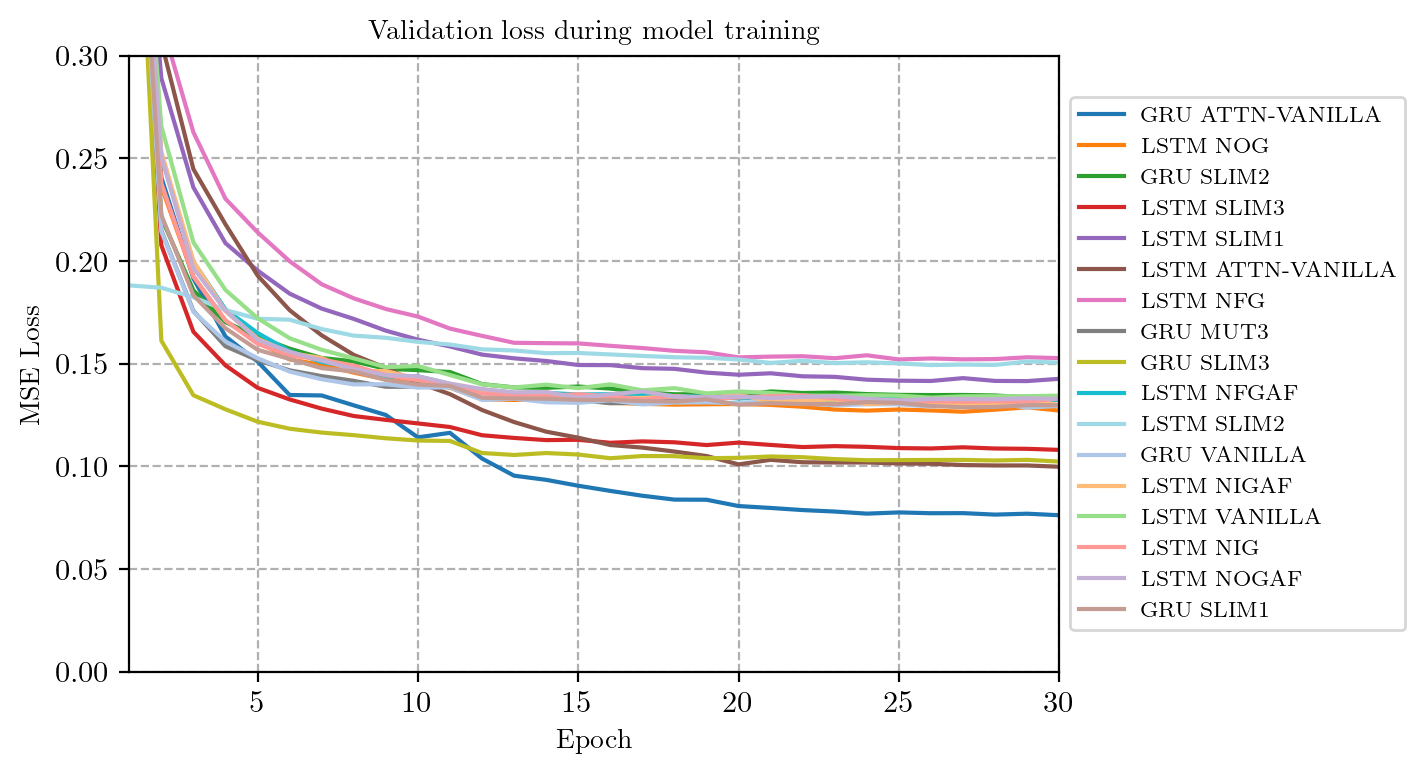

In [16]:
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in range(0,21,2)] + \
         [cmap(i+1) for i in range(0,21,2)]

# Get images folder and filepath
imagesfolder = os.path.join(utils.cwd, 'images')
filepath = os.path.join(imagesfolder,'training_validation_loss.pdf')

# Iterate over all elements in the folder
fig, ax = plt.subplots(figsize=(6,4))

# Iterate over all trained network
for i, (network_name, data) in enumerate(data_plot.items()):

    data = pd.Series(data['validation_loss'], data['epochs'])
            
    ax.plot(data.drop_duplicates(keep='first'), 
            label = network_name.replace('_',' ').upper(), 
            color = colors[i])

ax.set_title('Validation loss during model training', fontsize=10)
ax.set_xlabel('Epoch', fontsize=10)
ax.set_ylabel('MSE Loss', fontsize=10)
ax.set_ylim(0,0.3)
ax.set_xlim(1, 30)
ax.legend(fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True, linestyle='--')
fig.savefig(filepath, bbox_inches='tight')
    


In [27]:
reload(xnn)
# Get directory where the model parameters are saved.
folderpath = os.path.join(utils.cwd, 'models')

# Define batch_size for test
test_batch_size = 10

# Initialiaze dictionary to store the list
data_test = {}

# Iterate over all available networks
for network_name, network in networks.items():
    
    filepath = ''
    for filename in os.listdir(folderpath):
        if '_' + network_name + '_' in filename: 
            filepath = os.path.join(folderpath, filename)
            break

    if filepath=='': continue

    # Initialize model.
    print(f'\nNetwork: {network_name}')
    model = xnn.ConjunctionEventForecaster(network = network, 
                                           features = nn_features)
    
    # Load parameters into the model
    model.load(filepath = filepath)

    # Test model usinf the events_test dataset.
    test_results = model.test(events_test, test_batch_size = test_batch_size)

    # Add data to the dictionary.
    data_test[network_name] = test_results



Network: lstm_vanilla



| Progress                 |    Time     | Iters/sec | Comments
| 100% |██████████| (10/10)| 00h:00m:05s |   1.75    | Loss -> Mean = 1.7003e-01 Std. Dev. = 6.6358e-02

Network: lstm_slim1

| Progress                 |    Time     | Iters/sec | Comments
| 100% |██████████| (10/10)| 00h:00m:05s |   1.77    | Loss -> Mean = 1.6570e-01 Std. Dev. = 6.2071e-02

Network: lstm_slim2

| Progress                 |    Time     | Iters/sec | Comments
| 100% |██████████| (10/10)| 00h:00m:05s |   1.81    | Loss -> Mean = 1.8362e-01 Std. Dev. = 7.5217e-02

Network: lstm_slim3

| Progress                 |    Time     | Iters/sec | Comments
| 100% |██████████| (10/10)| 00h:00m:05s |   1.81    | Loss -> Mean = 1.3450e-01 Std. Dev. = 6.7906e-02

Network: lstm_nig

| Progress                 |    Time     | Iters/sec | Comments
| 100% |██████████| (10/10)| 00h:00m:05s |   1.75    | Loss -> Mean = 1.5527e-01 Std. Dev. = 8.5305e-02

Network: lstm_nog

| Progress                 |    Time     | Iters/sec 

In [32]:
mse_loss = {}
for network_name, data in data_test.items():
    mse_loss[network_name] = data['mse']

# Convert dictionary to Pandas DataFrame.
df_test_mse = pd.DataFrame.from_dict(data=mse_loss, orient='columns')

# Save results in a CSV file.
# df_test_loss.to_csv(f'networks_test_loss_bs{test_batch_size}.csv')

display(df_test_mse)

,lstm_vanilla,lstm_slim1,lstm_slim2,lstm_slim3,lstm_nig,lstm_nog,lstm_nfg,lstm_nigaf,lstm_nogaf,lstm_nfgaf,lstm_attn-vanilla,gru_vanilla,gru_slim1,gru_slim2,gru_slim3,gru_mut3,gru_attn-vanilla
0,0.103924,0.130420,0.157671,0.167605,0.135030,0.138650,0.131551,0.263003,0.207636,0.139682,0.132313,0.167899,0.123717,0.143097,0.213746,0.136598,0.105635
1,0.091977,0.216866,0.110252,0.171532,0.095846,0.170583,0.244814,0.102923,0.112129,0.122973,0.075254,0.225955,0.199580,0.126007,0.125903,0.127628,0.206221
2,0.148623,0.069106,0.283166,0.207329,0.134263,0.188361,0.168382,0.237571,0.115499,0.065010,0.076400,0.108527,0.130897,0.059252,0.157466,0.154060,0.036852
3,0.201452,0.143992,0.306945,0.088223,0.145828,0.292775,0.179260,0.125273,0.217006,0.118385,0.073107,0.174461,0.135876,0.096137,0.160545,0.152241,0.208498
4,0.310953,0.187351,0.203109,0.064068,0.218364,0.208446,0.116734,0.235310,0.283559,0.266938,0.210768,0.107306,0.098505,0.265739,0.141236,0.264646,0.099968
5,0.197721,0.302448,0.218526,0.051980,0.126214,0.061332,0.127156,0.184592,0.167744,0.211811,0.163507,0.137915,0.135787,0.301062,0.049443,0.123049,0.065041
6,0.136738,0.139509,0.057431,0.041476,0.370479,0.120320,0.142347,0.134046,0.112723,0.276478,0.067886,0.241007,0.306217,0.166215,0.078383,0.127712,0.070350
7,0.114728,0.131919,0.136737,0.205773,0.075780,0.089498,0.155860,0.094211,0.131584,0.154674,0.108660,0.133006,0.180943,0.310310,0.065783,0.046113,0.087534
8,0.224155,0.169657,0.178755,0.212505,0.095583,0.228015,0.266685,0.123207,0.125335,0.173083,0.092680,0.071560,0.128750,0.079241,0.140345,0.158791,0.031414
9,0.099900,0.300260,0.223793,0.119142,0.161113,0.108094,0.289294,0.090480,0.128909,0.065729,0.262468,0.172349,0.185966,0.107188,0.133390,0.284296,0.055217


In [74]:
# Model evaluation metrics:
# - SSE (Sum of Squared Errors)
# - MSE (Mean Squared Errors)
# - MAE (Mean Absolute Errors)
# - AIC (Akaike Information Criterion)
# - BIC (Bayesian Information Criterion): When fitting models, it is possible to 
#   increase the likelihood by adding parameters, but doing so may result in 
#   overfitting. BIC introduces a penalty term for the number of parameters in 
#   the model. The penalty term is larger in BIC than in AIC.
data_stats = {}
metrics = ['sse', 'mse', 'mae', 'aic', 'bic', 'apc', 'hsp']

df_stats = pd.DataFrame(index = list(data_test.keys()))
for metric in metrics:
    for network_name, data in data_test.items():
        
        data_stats[network_name] = data[metric]
    # Convert dictionary to Pandas DataFrame.
    df_metric = pd.DataFrame.from_dict(data=data_stats, orient='columns')
    
    df_metric = df_metric.describe().transpose()
    df_metric = df_metric[['mean', 'std','50%']].rename(columns={'mean':f'{metric}_mean', 
                                                           'std':f'{metric}_std',
                                                           '50%':f'{metric}_median'})

    df_stats = pd.concat([df_stats,df_metric], axis=1)


# Compute deltas vs min valua for AIC and BIC scores for reference
df_stats['aic_delta'] = df_stats['aic_mean']-df_stats['aic_mean'].min()
df_stats['bic_delta'] = df_stats['bic_std']-df_stats['bic_std'].min()
display(df_stats)

# Save to CSV regression scores.
df_stats.to_csv('networks_test_regression_scores.csv')



,sse_mean,sse_std,sse_median,mse_mean,mse_std,mse_median,mae_mean,mae_std,mae_median,aic_mean,...,bic_std,bic_median,apc_mean,apc_std,apc_median,hsp_mean,hsp_std,hsp_median,aic_delta,bic_delta
lstm_vanilla,2259.418494,969.721843,1977.552307,0.163017,0.069965,0.142681,0.160802,0.024376,0.158583,1.855577e+06,...,4.048624,2.136304e+06,-225.946720,96.974275,-197.759494,-0.000244,0.000105,-0.000213,11174.276122,0.819074
lstm_slim1,2483.056116,1043.060496,2173.583191,0.179153,0.075257,0.156824,0.159722,0.026476,0.163626,1.851268e+06,...,4.380231,2.131343e+06,-248.310977,104.308303,-217.363016,-0.000268,0.000113,-0.000235,6865.159386,1.150680
lstm_slim2,2600.668652,1057.272428,2646.319458,0.187638,0.076282,0.190932,0.161475,0.028358,0.157864,1.847513e+06,...,4.944579,2.127020e+06,-260.072496,105.729532,-264.637676,-0.000282,0.000114,-0.000286,3109.502315,1.715028
lstm_slim3,1842.872009,943.584375,1987.162231,0.132963,0.068080,0.143374,0.132721,0.030822,0.142685,1.853385e+06,...,6.190107,2.133782e+06,-184.291178,94.360474,-198.720512,-0.000199,0.000102,-0.000214,8981.482841,2.960557
lstm_nig,2160.080200,1182.605519,1866.202148,0.155850,0.085325,0.134647,0.155546,0.026582,0.166541,1.854545e+06,...,4.528462,2.135115e+06,-216.012679,118.263103,-186.624240,-0.000233,0.000128,-0.000201,10141.559651,1.298912
lstm_nog,2226.018140,979.456553,2142.982300,0.160607,0.070668,0.154616,0.156804,0.028334,0.161027,1.854545e+06,...,4.738672,2.135116e+06,-222.606615,97.947768,-214.302852,-0.000240,0.000106,-0.000231,10141.942017,1.509122
lstm_nfg,2525.407837,862.964364,2246.994507,0.182208,0.062263,0.162121,0.177361,0.020799,0.171878,1.854547e+06,...,3.244834,2.135117e+06,-252.546231,86.298298,-224.704297,-0.000272,0.000093,-0.000242,10143.661333,0.015284
lstm_nigaf,2204.593933,907.061413,1797.082214,0.159062,0.065445,0.129660,0.160487,0.027841,0.156174,1.855577e+06,...,4.038186,2.136303e+06,-220.464146,90.708097,-179.712095,-0.000238,0.000098,-0.000194,11174.049188,0.808636
lstm_nogaf,2220.543201,804.572130,1805.216736,0.160212,0.058050,0.130247,0.160745,0.031739,0.161651,1.855578e+06,...,3.274587,2.136303e+06,-222.059107,80.458947,-180.525565,-0.000239,0.000087,-0.000195,11174.349469,0.045037
lstm_nfgaf,2210.342694,1025.907417,2039.887329,0.159476,0.074019,0.147178,0.159494,0.025684,0.157731,1.855577e+06,...,5.061598,2.136304e+06,-221.039034,102.592953,-203.993130,-0.000238,0.000111,-0.000220,11173.745613,1.832047


In [79]:
# Display test loss dataframe and statistics
#df_test_mse = pd.read_csv('networks_test_mse_bs10.csv',index_col=0)

data_mse = {}
for network_name, data in data_test.items():
    data_mse[network_name] = data['mse']

# Convert dictionary to Pandas DataFrame.
df_test_mse = pd.DataFrame.from_dict(data=data_stats, orient='columns')

df_test_mse_stats = df_stats[[c for c in df_stats.columns if c.startswith('mse_')]]
df_test_mse_stats.sort_values(by='mse_mean', inplace=True)

# Get statistics from results of model on the test dataset
# df_test_mse_stats = df_test_mse.describe().transpose()
# df_test_mse_stats.sort_values(by='mean', ascending=True, inplace=True)

vanilla_loss = df_stats.loc['lstm_vanilla']['mse_mean']

# df_test_mse_stats = df_test_mse_stats[['mean', 'std', '50%']].rename(columns={'50%':'median'}, inplace=False)

df_test_mse_stats['delta'] = (vanilla_loss - df_test_mse_stats['mse_mean'])/vanilla_loss

# Reorder the columns in the original dataset to be ordered by the loss mean
df_test_mse = df_test_mse[df_test_mse_stats.index]

display(df_test_mse)
display(df_test_mse_stats)

/var/folders/m2/1phpry2j5w739bgs4cqbg0pw0000gn/T/ipykernel_25178/1524352695.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_mse_stats.sort_values(by='mse_mean', inplace=True)
/var/folders/m2/1phpry2j5w739bgs4cqbg0pw0000gn/T/ipykernel_25178/1524352695.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_mse_stats['delta'] = (vanilla_loss - df_test_mse_stats['mse_mean'])/vanilla_loss


,gru_attn-vanilla,lstm_attn-vanilla,gru_slim3,lstm_slim3,gru_vanilla,lstm_nig,gru_mut3,lstm_nigaf,lstm_nfgaf,lstm_nogaf,lstm_nog,gru_slim1,lstm_vanilla,gru_slim2,lstm_slim1,lstm_nfg,lstm_slim2
0,-0.000159,-0.000198,-0.000320,-0.000251,-0.000251,-0.000202,-0.000204,-0.000393,-0.000209,-0.000310,-0.000207,-0.000185,-0.000155,-0.000214,-0.000195,-0.000197,-0.000237
1,-0.000310,-0.000113,-0.000188,-0.000257,-0.000338,-0.000143,-0.000191,-0.000154,-0.000184,-0.000168,-0.000255,-0.000299,-0.000137,-0.000189,-0.000325,-0.000366,-0.000165
2,-0.000055,-0.000114,-0.000236,-0.000310,-0.000163,-0.000201,-0.000230,-0.000355,-0.000097,-0.000173,-0.000282,-0.000196,-0.000222,-0.000089,-0.000103,-0.000252,-0.000425
3,-0.000313,-0.000109,-0.000240,-0.000132,-0.000261,-0.000218,-0.000228,-0.000187,-0.000177,-0.000324,-0.000438,-0.000203,-0.000301,-0.000144,-0.000216,-0.000268,-0.000461
4,-0.000150,-0.000315,-0.000211,-0.000096,-0.000161,-0.000326,-0.000396,-0.000352,-0.000399,-0.000424,-0.000312,-0.000147,-0.000465,-0.000398,-0.000281,-0.000174,-0.000305
5,-0.000098,-0.000244,-0.000074,-0.000078,-0.000207,-0.000189,-0.000184,-0.000276,-0.000316,-0.000251,-0.000092,-0.000203,-0.000295,-0.000451,-0.000453,-0.000190,-0.000328
6,-0.000106,-0.000102,-0.000117,-0.000062,-0.000361,-0.000554,-0.000191,-0.000200,-0.000413,-0.000168,-0.000180,-0.000458,-0.000204,-0.000249,-0.000209,-0.000213,-0.000086
7,-0.000132,-0.000162,-0.000098,-0.000308,-0.000199,-0.000113,-0.000069,-0.000141,-0.000231,-0.000197,-0.000134,-0.000271,-0.000171,-0.000465,-0.000198,-0.000233,-0.000205
8,-0.000047,-0.000139,-0.000210,-0.000318,-0.000107,-0.000143,-0.000237,-0.000184,-0.000259,-0.000187,-0.000341,-0.000193,-0.000335,-0.000119,-0.000254,-0.000399,-0.000268
9,-0.000083,-0.000392,-0.000200,-0.000178,-0.000258,-0.000241,-0.000425,-0.000135,-0.000098,-0.000193,-0.000162,-0.000278,-0.000149,-0.000161,-0.000450,-0.000432,-0.000336


,mse_mean,mse_std,mse_median,delta
gru_attn-vanilla,0.096673,0.063184,0.078942,0.406977
lstm_attn-vanilla,0.126304,0.066563,0.100670,0.225210
gru_slim3,0.126624,0.049583,0.136867,0.223247
lstm_slim3,0.132963,0.068080,0.143374,0.184360
gru_vanilla,0.153998,0.053167,0.152907,0.055324
lstm_nig,0.155850,0.085325,0.134647,0.043966
gru_mut3,0.157513,0.069450,0.144419,0.033763
lstm_nigaf,0.159062,0.065445,0.129660,0.024265
lstm_nfgaf,0.159476,0.074019,0.147178,0.021721
lstm_nogaf,0.160212,0.058050,0.130247,0.017206


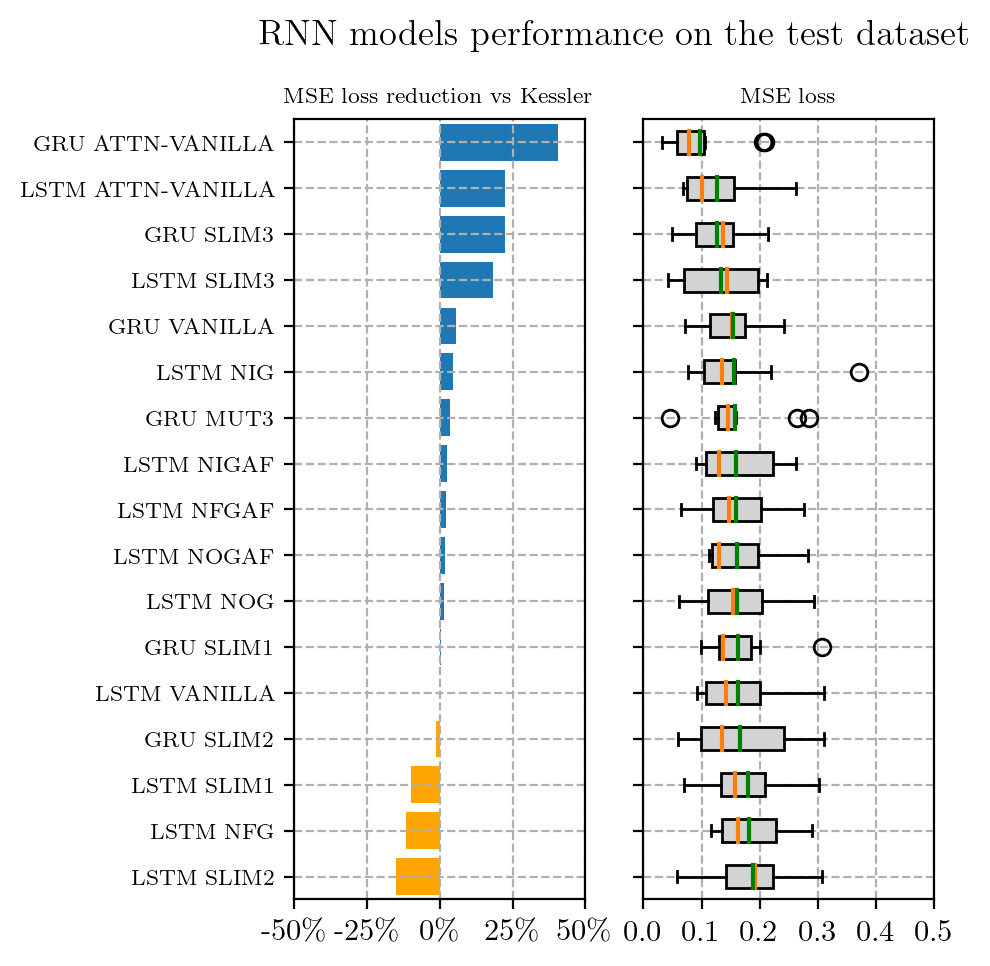

In [39]:
import matplotlib.ticker as mtick

fig, (ax_hb, ax_bp) = plt.subplots(nrows=1, ncols=2, figsize=(4,5), sharey=True)

fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    wspace=0.2,
                    hspace=0.4)

# Set the figure title
fig.suptitle('RNN models performance on the test dataset') 

# Get the labels for the Y-axis
labels = [l.replace('_',' ').upper() for l in df_test_mse.columns]

# Plot the boxplot

ax_bp.boxplot(df_test_mse, positions = np.arange(len(labels)), 
              vert = False, showmeans = True, meanline = True, 
              meanprops = dict(linestyle='-', linewidth=1.5, color='green'), 
              medianprops = dict(linewidth=1.5), 
              boxprops = dict(facecolor = "lightgrey"), 
              showfliers = True, patch_artist=True)

# Set the Y-axis labels to the right position for the boxplot.
#ax_bp.yaxis.set_ticks_position('right')

# Set the X-axis label and ticks for the boxplot
ax_bp.set_title('MSE loss', fontsize=8)
ax_bp.set_xticks(np.linspace(0,0.5,6))

# Plot horizontalm bars with the delta.
colors = ['tab:blue']*sum(df_test_mse_stats['delta']>0) + \
    ['orange']*sum(df_test_mse_stats['delta']<=0)
ax_hb.barh(labels, df_test_mse_stats['delta'], color = colors, align='center')

# Set the X-axis label and format for the ticks
ax_hb.set_title('MSE loss reduction vs Kessler', fontsize=8)
ax_hb.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

# Set the limits and ticks for the horizontal bar plot
ax_hb.set_xlim(-0.5,0.5)
ax_hb.set_xticks(np.linspace(-0.5,0.5,5))


# Set general format for both plots 
for ax in [ax_bp, ax_hb]: ax.grid(True, linestyle='--')
ax_hb.set_yticklabels(labels, fontsize=8)
       
ax_hb.invert_yaxis()

fig.savefig('rnn_models_performance.pdf', bbox_inches = "tight")
fig.savefig('rnn_models_performance.png',dpi=300, bbox_inches = "tight")
